# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 990.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [61]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# A test if missing data is found correctly
# print(data.iloc[5:8, 1:2])
# data.iloc[5:8, 1:2] = None
# print(data.iloc[5:8, 1:2])

# Checking for missing data with only specific columns for rows with missing data
missing_data_total = data.isna().sum().sum()
rows_with_missing = data[data.isna().any(axis=1)]
print(f'Total amount of missing data: {missing_data_total}')
for index, row in rows_with_missing.iterrows():
    missing_columns = row[row.isna()].index
    print(f"Data missing in row: {index}, and column: {', '.join(missing_columns)}")


The number of samples: 186
The number of columns: 494
Total amount of missing data: 0


**Imports**

Import all modules necessary for this Jupyter Notebook


In [3]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import datasets as ds

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# Basic Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


**Definitions applied in this Jupyter Notebook**

In [4]:
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm


**Data Visualization**

In [5]:
# Code for data visualization

**PRE PROCESSING**

Pre processing contains the following: ...

In [6]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, StratifiedKFold

# Pre processing
#
# Splitting
df_data = pd.DataFrame(data)
X = df_data.iloc[:, 1:]  # Feature set
y = df_data.iloc[:, :1]  # Classification Benign/Malignant

# Change classification (Benign/Malignant) to binary values
y['label'] = y.replace({'benign': 0, 'malignant': 1})

# Stratified K-Fold Split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Splitting data in Test and Train set
for train_index, test_index in skf.split(X, y):
    X_pre_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_pre_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Splitting data in Train and validation set
for train_index, test_index in skf.split(X_pre_train, y_pre_train):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

# print(y_train)
# print(f'The number of samples: {len(y_train)}')
# print(f'test{y_test}')
# print(f'The number of samples: {len(y_test)}')
# print(f'val{y_val}')
# print(f'The number of samples: {len(y_val)}')


<ipython-input-6-fcfbe0828860>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['label'] = y.replace({'benign': 0, 'malignant': 1})


**Scaling**

In [7]:
# Scaling

# # General packages
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn import datasets as ds
# import seaborn

# # Classifiers
# from sklearn import model_selection
# from sklearn import metrics
# from sklearn import feature_selection
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import svm

# from sklearn import decomposition

# Scale the data to be normal
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# # Feature selection
# # Create the RFE object and compute a cross-validated score.
# svc = svm.SVC(kernel="linear")

# # classifications
# rfecv = feature_selection.RFECV(
#     estimator=svc, step=1,
#     cv=model_selection.StratifiedKFold(4),
#     scoring='roc_auc')
# rfecv.fit(X, y)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
# plt.show()

# Perform a PCA
pca = decomposition.PCA(n_components=2)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

y_train_list = y_train['label'].tolist()
print(y_train_list)

[0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1]


# Classifiers

**Basic Classifiers**

Number of mislabeled points out of a total 120 points : 59


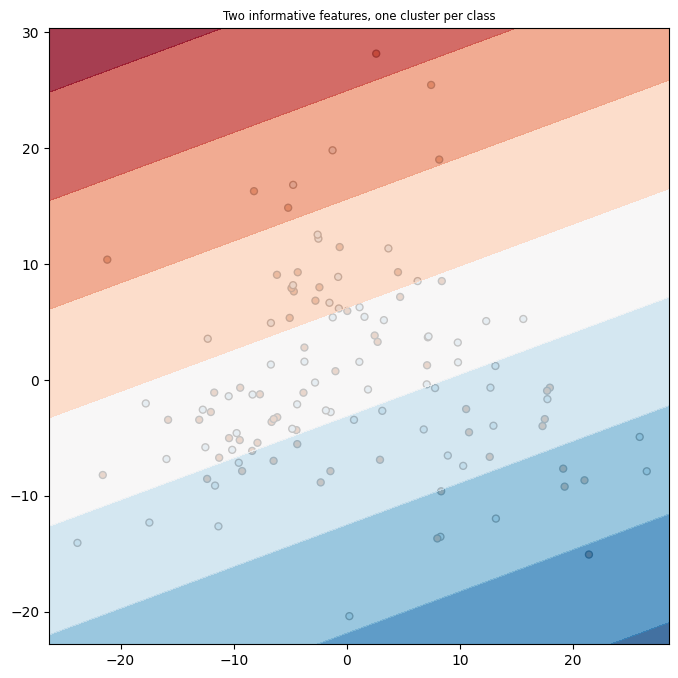

In [8]:
# # General packages
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import datasets as ds
# from sklearn import metrics

# # Metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# # Basic Classifiers
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier

# Linear classifier
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Two informative features, one cluster per class",
             fontsize='small')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=y_train_list,
           s=25, edgecolor='k', cmap=plt.cm.Paired)
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_pca, y_train_list)
y_pred = lda.predict(X_train_pca)
colorplot(lda, ax, X_train_pca[:, 0], X_train_pca[:, 1])
print("Number of mislabeled points out of a total %d points : %d" % (X_train_pca.shape[0], (y_train_list != y_pred).sum()))


**Basic classifiers: Gaussian, LDA, QDA, Logistic regression, SDG, KNN & Decision Tree**

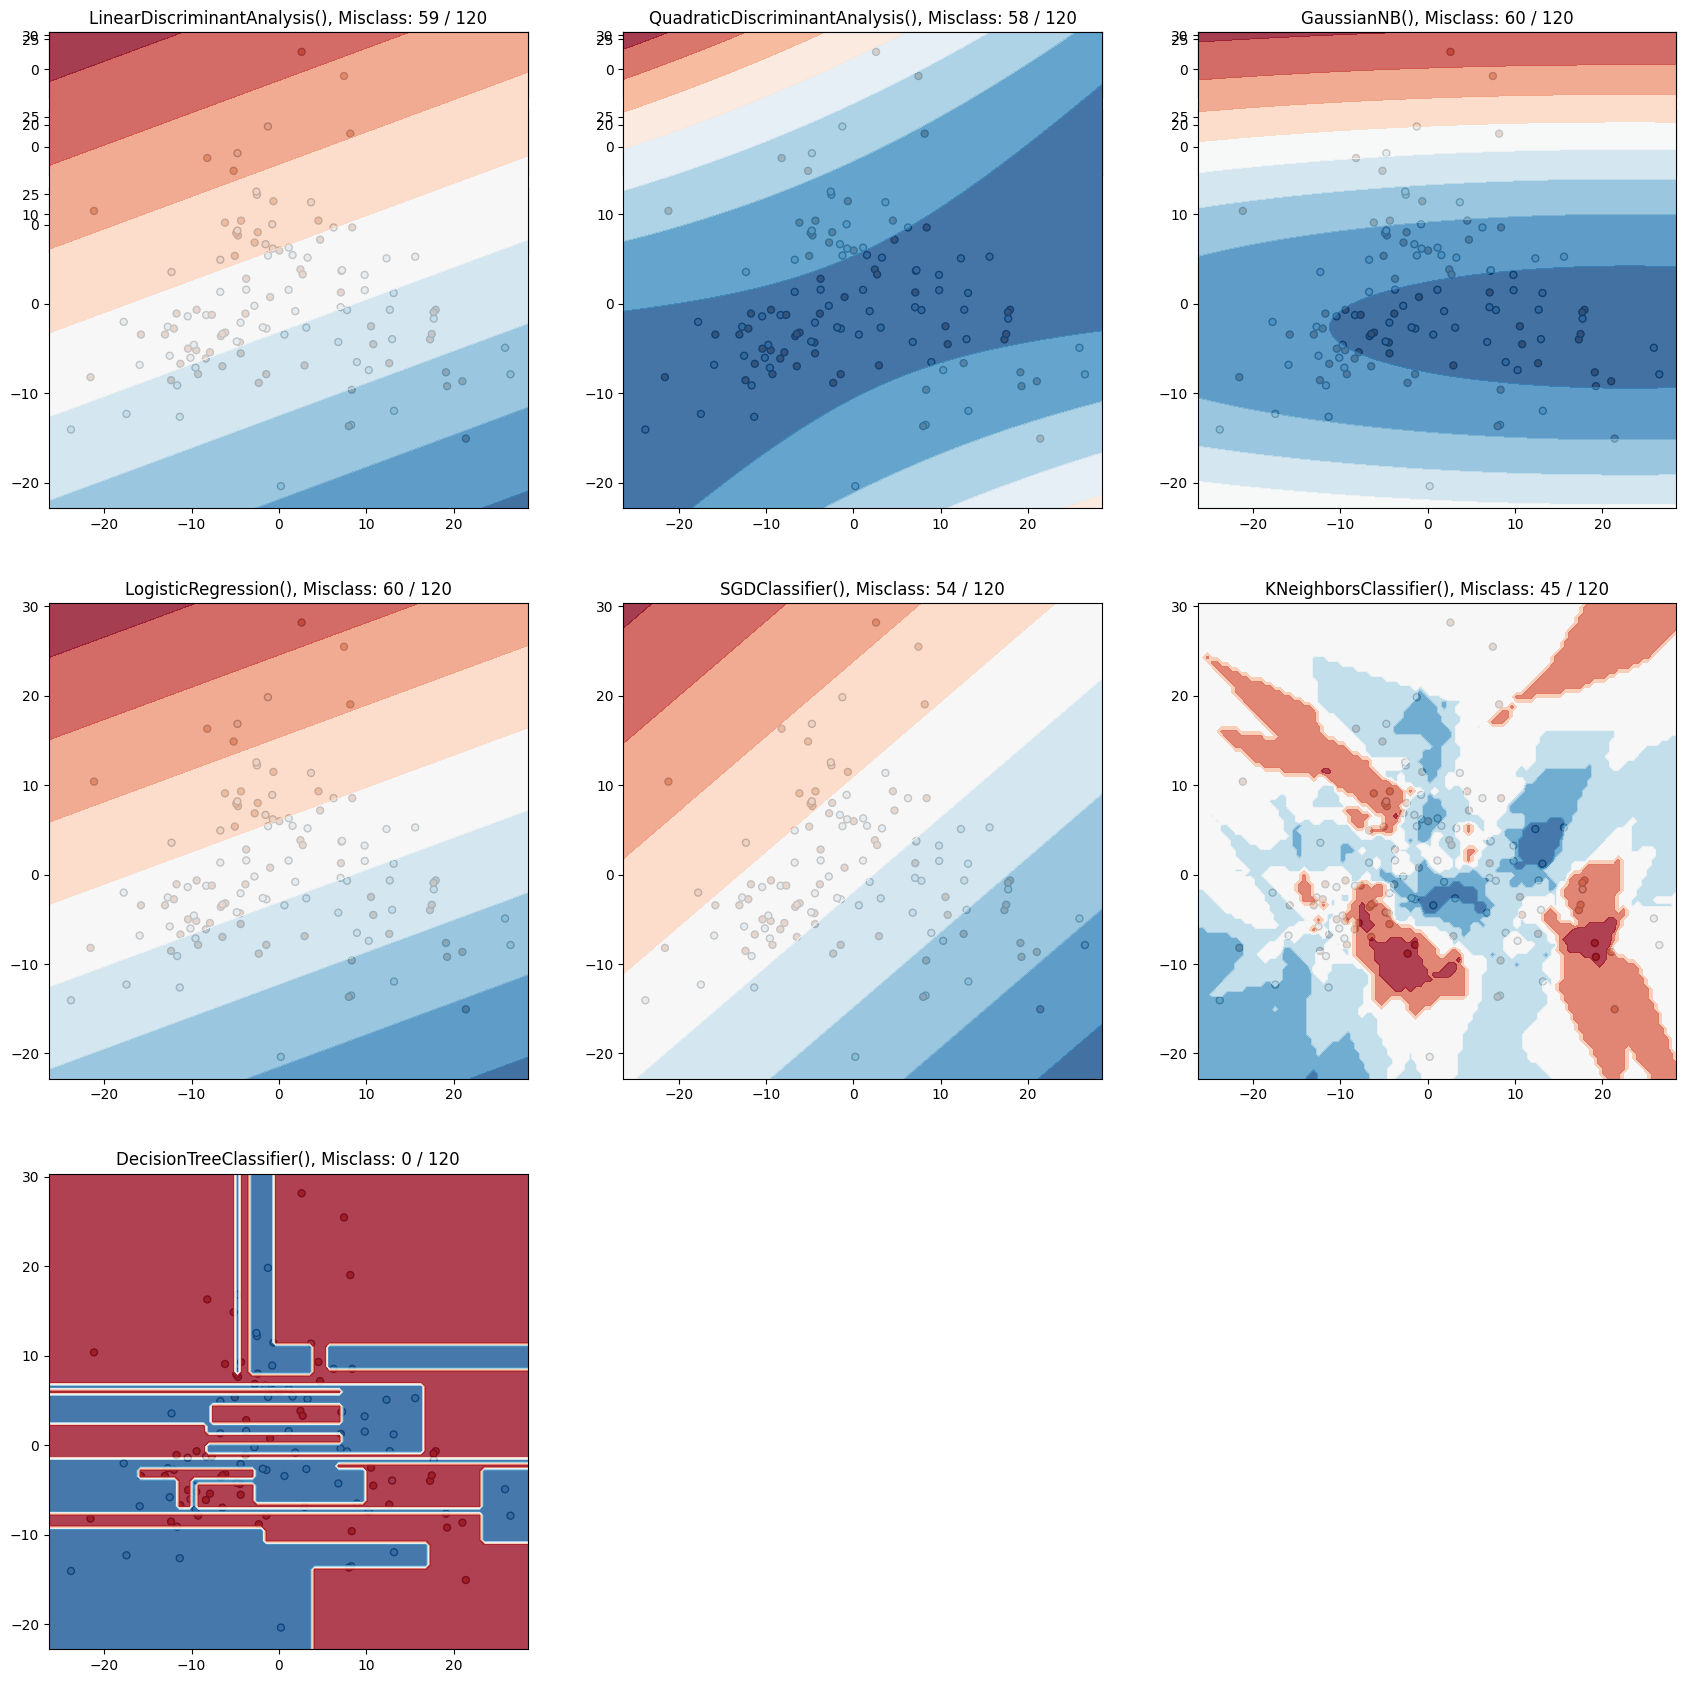

In [9]:
# Plot several basic classifiers and plot the result. Define misclasses
clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),KNeighborsClassifier(),DecisionTreeClassifier()]
Xs = X_train_pca
Ys = y_train_list
clfs_fit = list()

# First make a plot without classifiers:
fig = plt.figure(figsize=(21,3*len(clsfs)))
num = 0  # Iteration number for the subplots

for num in range(0,7):
    ax = fig.add_subplot(21, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)


# Fit the classifiers and add them to the plot
num=0
Xt=list()
Yt=list()
for clf in clsfs:
    # Fit classifier
    clf.fit(Xs,Ys)
    y_pred=clf.predict(Xs)
    # Predict labels using fitted classifier

    # Make scatterplot of features
    ax = fig.add_subplot(3, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, Xs[:,0], Xs[:,1])
    # Add overlay through colorplot function
    t=(f"{clf}, Misclass: %d / %d" % ((Ys!=y_pred).sum(), Xs.shape[0]))
    ax.set_title(t)
    num+=1

    clfs_fit.append(clf)
    Xt.append(Xs)
    Yt.append(Ys)


**KNN**

In [10]:
# Fit kNN
knn = neighbors.KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train_pca, y_train)
score_train = knn.score(X_train_pca, y_train)
score_test = knn.score(X_test_pca, y_test)

# Print result
print(f"Training result: {score_train}")
print(f"Test result: {score_test}")

Training result: 0.6416666666666667
Test result: 0.5945945945945946


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
